Plot area taus for all sampling iterations.


In [27]:
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import seaborn as sns

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
#os.chdir(os.path.abspath("C:\\Users\\ipoch\\Documents\\repos\\isttc\\scripts"))
from calculate_tau import fit_single_exp, fit_single_exp_2d, func_single_exp_monkey
from cfg_global import project_folder_path
os.chdir(current_wd)

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [29]:
save_fig = True

In [3]:
def prep_trials_dfs(trial_dict, acf_cols_, units_info_df_subset_):
    random_acfs = np.random.randint(0, 100, size=len(trial_dict))  
    print(f'random_acfs shape {random_acfs.shape}')

    unit_id_no_dupl_l, trial_acf_random_l = [], []
    for idx, (k,v) in enumerate(trial_dict.items()):    
        unit_id_no_dupl_l.append(k)
        trial_acf_random_l.append(v['acf'][random_acfs[idx]])

    trial_acf_random_df = pd.DataFrame(np.vstack(trial_acf_random_l), columns=acf_cols_)
    trial_acf_random_df.insert(0, 'unit_id', np.hstack(unit_id_no_dupl_l))
    trial_acf_random_df = pd.merge(trial_acf_random_df, units_info_df_subset_, on='unit_id', how='left')
    print(f'N units trial_acf_random_df: {len(trial_acf_random_df)}')
    # might be NaNs here
    rows_with_nans_df = trial_acf_random_df[trial_acf_random_df.isna().any(axis=1)]
    n_rows_with_nan = len(rows_with_nans_df)
    trial_acf_random_df.dropna(inplace=True)
    print(f'N n_rows_with_nan {n_rows_with_nan} removing... new N: {len(trial_acf_random_df)}')

    return trial_acf_random_df

In [4]:
def calc_population_tau_2d(acf_df_, acf_cols_, start_idx_, func_to_fit_, verbose_=False):
    acf_2d = acf_df_[acf_cols_].values
    fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp_2d(acf_2d, start_idx_, func_to_fit_)
    if verbose_:
        print(f'tau {tau*50}, 95% CI {tau_ci[0]*50},{tau_ci[1]*50}')
    return {'tau_ms':tau*50,
            'tau_lower_ms':tau_ci[0]*50, 
            'tau_upper_ms':tau_ci[1]*50, 
            'fit_r_squared': fit_r_squared, 
            'explained_var': explained_var, 
            'popt': fit_popt,
            'n_acfs': len(acf_df_)}

def get_method_tau_dict(areas_, acf_df_, acf_cols_, verbose_=False):
    taus_dict = {}
    for area in areas_:
        if verbose_:
            print(f'processing area {area}')
        acf_df_area = acf_df_.query('ecephys_structure_acronym == @area').copy()
        if verbose_:
            print(f'N units for brain area {area}: {len(acf_df_area)}')
        taus_dict[area] = calc_population_tau_2d(acf_df_area, acf_cols_, 2, func_single_exp_monkey)
    return taus_dict

In [5]:
dataset_folder = project_folder_path + 'results\\allen_mice\\dataset\\cut_30min\\'
fig_folder = project_folder_path + 'results\\allen_mice\\fig_draft_paper\\'

#### Load data

In [6]:
with open(dataset_folder + 'area_taus_dict.json', 'r') as f:
    area_taus_dict = json.load(f)

In [12]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

units_info_df = pd.read_pickle(dataset_folder + 'sua_list_constrained_units_df.pkl')
units_info_df_subset = units_info_df[['unit_id', 'ecephys_structure_acronym', 'fr_hz_spont_30min']].copy()

with open(dataset_folder + 'binned\\pearsonr_trial_avg_50ms_20lags_dict.pkl', "rb") as f:
    pearsonr_trial_avg_trial_dict = pickle.load(f)
print(f'N signals pearsonr_trial_avg_trial_dict {len(pearsonr_trial_avg_trial_dict)}')

with open(dataset_folder + 'non_binned\\sttc_trial_avg_50ms_20lags_dict.pkl', "rb") as f:
    sttc_trial_avg_trial_dict = pickle.load(f)
print(f'N signals sttc_trial_avg_trial_dict {len(sttc_trial_avg_trial_dict)}')

with open(dataset_folder + 'non_binned\\sttc_trial_concat_50ms_20lags_dict_25dt.pkl', "rb") as f:
    sttc_trial_concat_trial_dict = pickle.load(f)
print(f'N signals sttc_trial_concat_trial_dict {len(sttc_trial_concat_trial_dict)}')

brain_areas = units_info_df['ecephys_structure_acronym'].unique()
print(f'brain_areas {brain_areas}')

n_samples = 50

area_taus_dict_random = {}
for ii in range(n_samples):
    # using random ACF per unit 
    print(f'Processing {ii}...')
    pearsonr_trial_avg_acf_random_df = prep_trials_dfs(pearsonr_trial_avg_trial_dict,
                                                                                acf_cols[:-1], units_info_df_subset) 
    sttc_trial_avg_acf_random_df = prep_trials_dfs(sttc_trial_avg_trial_dict,
                                                                                    acf_cols[:-1], units_info_df_subset) 
    sttc_trial_concat_acf_random_df = prep_trials_dfs(sttc_trial_concat_trial_dict,
                                                                                    acf_cols[:-1], units_info_df_subset) 
    
    acf_pearsonr_trial_avg_taus_random_dict = get_method_tau_dict(brain_areas, pearsonr_trial_avg_acf_random_df, acf_cols[:-1])
    acf_sttc_trial_avg_taus_random_dict = get_method_tau_dict(brain_areas, sttc_trial_avg_acf_random_df, acf_cols[:-1])
    acf_sttc_trial_concat_taus_random_dict = get_method_tau_dict(brain_areas, sttc_trial_concat_acf_random_df, acf_cols[:-1])
    
    area_taus_dict_random[ii] = {'pearsonr_trial_avg_random': acf_pearsonr_trial_avg_taus_random_dict, 
                  'sttc_trial_avg_random': acf_sttc_trial_avg_taus_random_dict, 
                  'sttc_trial_concat_random': acf_sttc_trial_concat_taus_random_dict}

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']
N signals pearsonr_trial_avg_trial_dict 5775
N signals sttc_trial_avg_trial_dict 5775
N signals sttc_trial_concat_trial_dict 5775
brain_areas ['VISam' 'LP' 'VISp' 'VISl' 'LGd' 'VISal' 'VISrl' 'VISpm']
Processing 0...
random_acfs shape (5775,)
N units trial_acf_random_df: 5775
N n_rows_with_nan 996 removing... new N: 4779
random_acfs shape (5775,)
N units trial_acf_random_df: 5775
N n_rows_with_nan 0 removing... new N: 5775
random_acfs shape (5775,)
N units trial_acf_random_df: 5775
N n_rows_with_nan 0 removing... new N: 5775
Processing 1...
random_acfs shape (5775,)
N units trial_acf_random_df: 5775
N n_rows_with_nan 1022 removing... new N: 4753
random_acfs shape (5775,)
N units trial_acf_random_df: 5775
N n_rows_with_nan 0 removing... new N: 5775
random_acfs shape (5775,)
N unit

In [13]:
# make a df for plotting
rows = []

for outer_key, method_dict in area_taus_dict_random.items():
    for method, area_dict in method_dict.items():
        for area, metrics in area_dict.items():
            row = {
                'iteration': outer_key,  # or whatever you want to name it
                'method': method,
                'area': area
            }
            row.update(metrics)
            rows.append(row)

df_all = pd.DataFrame(rows)

In [21]:
df_all

,iteration,method,area,tau_ms,tau_lower_ms,tau_upper_ms,fit_r_squared,explained_var,popt,n_acfs
0,0,pearsonr_trial_avg_random,VISam,329.640691,257.107520,402.173862,0.062148,0.062148,"[0.14712120059586928, 6.592813820656869, 0.464...",751
1,0,pearsonr_trial_avg_random,LP,235.043413,198.621312,271.465514,0.101765,0.101765,"[0.20095848405032876, 4.7008682601955405, 0.26...",580
2,0,pearsonr_trial_avg_random,VISp,289.479443,240.580997,338.377890,0.078631,0.078631,"[0.18081742127617875, 5.789588866180184, 0.304...",827
3,0,pearsonr_trial_avg_random,VISl,327.761474,256.158053,399.364896,0.079527,0.079527,"[0.17394785558250384, 6.555229488995164, 0.303...",578
4,0,pearsonr_trial_avg_random,LGd,297.011511,209.636986,384.386035,0.087217,0.087217,"[0.1817947106877114, 5.940230210241651, 0.4195...",252
...,...,...,...,...,...,...,...,...,...,...
1195,49,sttc_trial_concat_random,VISl,333.076931,264.861052,401.292811,0.073755,0.073755,"[0.14085305116953317, 6.661538623066942, 0.238...",727
1196,49,sttc_trial_concat_random,LGd,340.175814,222.853710,457.497918,0.076769,0.076769,"[0.14769594173656972, 6.803516281047246, 0.387...",254
1197,49,sttc_trial_concat_random,VISal,343.328626,277.272582,409.384671,0.068982,0.068982,"[0.13082149061525045, 6.866572529610609, 0.292...",928
1198,49,sttc_trial_concat_random,VISrl,310.394560,244.610225,376.178894,0.065093,0.065093,"[0.13296933476974115, 6.207891198330772, 0.307...",706


In [32]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()  # Convert ndarray to list
        return super().default(obj)

with open(dataset_folder + 'area_taus_dict_random.json', 'w') as f:
    json.dump(area_taus_dict_random, f, cls=NumpyEncoder, indent=4)  

#### Plots

In [14]:
color_acf_full = '#4783B4'
color_isttc_full = '#E2552A'
color_pearson_trail_avg = 'slategray' 
color_sttc_trail_avg =  '#E97451' 
color_sttc_trail_concat = '#B94E48' 

colors=[color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_avg, color_sttc_trail_concat]

brain_areas_axes_ticks = ['LGd', 'VISp', 'VISl', 'VISrl', 'LP', 'VISal', 'VISpm', 'VISam']
brain_areas_names = ['LGN', 'V1', 'LM', 'RL', 'LP', 'AL', 'PM', 'AM']

In [15]:
# make a df for plotting
rows = []

for method, area_dict in area_taus_dict.items():
    for area, metrics in area_dict.items():
        row = {
            'method': method,
            'area': area
        }
        row.update(metrics)
        rows.append(row)

df_all_full = pd.DataFrame(rows)

df_all_full_subset = df_all_full[df_all_full['method'].isin(['acf_full', 'isttc_full', 'pearsonr_trial_avg_random',
                                                             'sttc_trial_avg_random', 'sttc_trial_concat_random'])].copy()

In [22]:
df_all_full_subset.query('area == @area')

,method,area,tau_ms,tau_lower_ms,tau_upper_ms,fit_r_squared,explained_var,popt,n_acfs
4,acf_full,LGd,333.665117,263.428446,403.901788,0.159908,0.159908,"[0.16897765886171892, 6.673302345693106, 0.418...",254
12,isttc_full,LGd,329.386654,256.819691,401.953618,0.145761,0.145761,"[0.14533216625205883, 6.587733086883628, 0.438...",254
68,pearsonr_trial_avg_random,LGd,289.627184,202.230126,377.024243,0.080777,0.080777,"[0.1739698523389087, 5.792543687365002, 0.4366...",252
76,sttc_trial_avg_random,LGd,283.390070,196.096848,370.683292,0.075294,0.075294,"[0.1508981909921037, 5.667801399851507, 0.5088...",254
84,sttc_trial_concat_random,LGd,288.402950,204.792535,372.013365,0.085871,0.085871,"[0.15093933133700585, 5.768058997023292, 0.410...",254


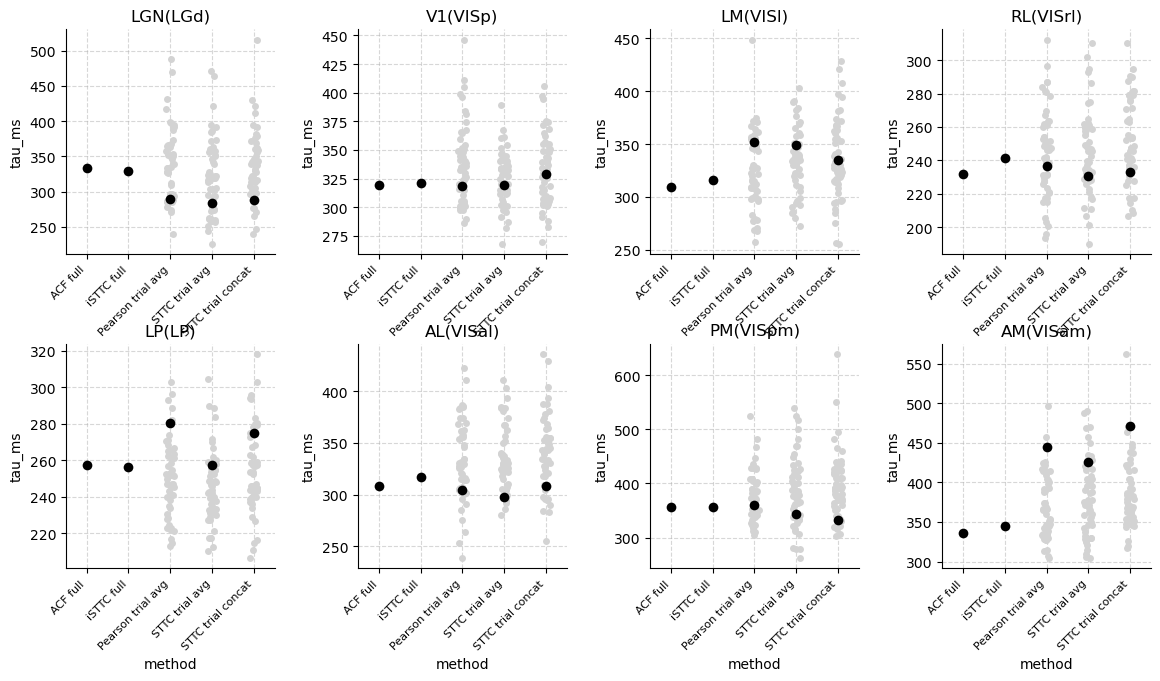

In [30]:
categories = ['acf_full', 'isttc_full', 'pearsonr_trial_avg_random', 'sttc_trial_avg_random', 'sttc_trial_concat_random']
custom_labels = ['ACF full', 'iSTTC full', 'Pearson trial avg', 'STTC trial avg', 'STTC trial concat']

fig, axes = plt.subplots(2, 4, figsize=(14, 7), sharey=False)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for area_idx, area in enumerate(brain_areas_axes_ticks):
    y_idx = area_idx % 4 
    x_idx = area_idx // 4
    sns.stripplot(data=df_all.query('area == @area'), x='method', y='tau_ms', color='lightgray', order=categories, 
                  ax=axes[x_idx, y_idx])
    sns.stripplot(data=df_all_full_subset.query('area == @area'), x='method', y='tau_ms', color='k', s=7, order=categories, 
                  ax=axes[x_idx, y_idx])
    axes[x_idx, y_idx].set_title(f'{brain_areas_names[area_idx]}({brain_areas_axes_ticks[area_idx]})')
    
for ax in axes.flat:
    ax.grid(True, linestyle='--', alpha=0.5)
    sns.despine(ax=ax)
    ax.xaxis.set_major_locator(FixedLocator(range(len(categories))))
    ax.set_xticklabels(custom_labels, rotation=45, ha='right', fontsize=8)

if save_fig:
    fig.savefig(fig_folder + 'tau_per_area_5methods_50_trial_iterations.png', bbox_inches='tight', dpi=300)
    fig.savefig(fig_folder + 'tau_per_area_5methods_50_trial_iterations.svg', bbox_inches='tight')